In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from operator import eq
import pandas as pd
#import pandas_ta as ta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

import datetime
from pathlib import Path

## IMPORT SKLEARN
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

import numpy as np
plt.style.use('seaborn')
from pprint import pprint

In [3]:
# IMPORT TENSORFLOW AND KERAS
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

df = pd.DataFrame()

In [4]:


def set_seeds(seed=2022): 
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)



In [5]:
equityData = data = yf.download('BTC-USD', start="2017-08-01",end="2022-10-03")
equityData.dropna(inplace=True)
equityData.drop(index=equityData.index[0], axis=0, inplace=True)
equityData.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-01,2871.300049,2921.350098,2685.610107,2718.260010,2718.260010,1324669952
2017-08-02,2727.129883,2762.530029,2668.590088,2710.669922,2710.669922,1094950016
2017-08-03,2709.560059,2813.310059,2685.139893,2804.729980,2804.729980,804796992
2017-08-04,2806.929932,2899.330078,2743.719971,2895.889893,2895.889893,1002120000
2017-08-05,2897.629883,3290.010010,2874.830078,3252.909912,3252.909912,1945699968


In [22]:
equityData.to_excel('StockDataCSV/BTCBotData.xlsx')


In [33]:
equityData.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-28,19104.621094,19688.343750,18553.296875,19426.720703,19426.720703,53071298734
2022-09-29,19427.779297,19589.265625,18924.353516,19573.050781,19573.050781,41037843771
2022-09-30,19573.431641,20109.849609,19265.662109,19431.789062,19431.789062,43975248085
2022-10-01,19431.105469,19471.154297,19231.082031,19312.095703,19312.095703,18719537670
2022-10-02,19311.849609,19370.308594,18970.621094,19044.107422,19044.107422,20765955327


In [6]:
### Path to store results

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [7]:
data = equityData['Adj Close']

data = data.to_numpy()
data = np.reshape(data, (-1, 1))
data.shape

(1889, 1)

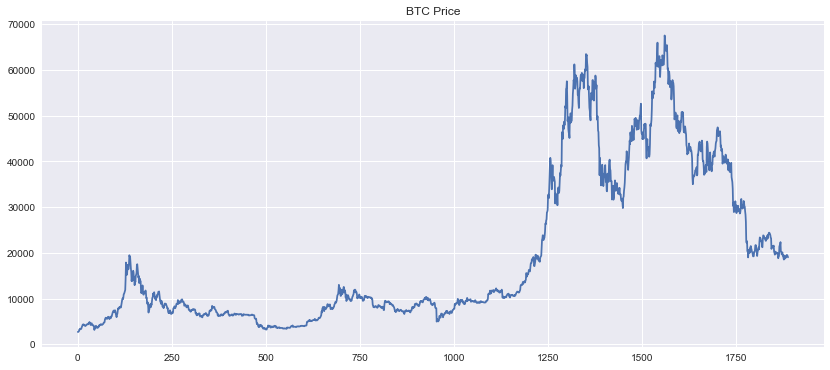

In [8]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('BTC Price')
plt.plot(data);

In [9]:
#### TRAIN - TEST SPLIT
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 1511, 378


In [10]:
#### PREPROCESSING
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [11]:
#### GENERATE SEQUENCE

def generate_sequence(data, sequence_length=60):
    
    # create X & y data array
    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [12]:
# sequence length
lookback = 60

In [13]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (1451, 60), y_train (1451,)


In [14]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (318, 60), y_test (318,)


In [15]:
#### RESHAPE

# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis] 

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (1451, 60, 1), y_train (1451, 1)


In [16]:
# reshaping test array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

# check the test array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (318, 60, 1), y_test (318, 1)


In [17]:
#### CREATE THE MODEL
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()   
    
    # instantiate the model
    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, 1), activation = 'relu', return_sequences=False, name='LSTM'))
    model.add(Dense(units=1, name='Output'))              # can also specify linear activation function 
    
    # specify optimizer separately (preferred method))
#     opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       # adam optimizer seems to perform better for a single lstm
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [18]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [19]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [20]:
#### TRAIN THE MODEL
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [21]:
# Model fitting
lstm_training = model.fit(X_train, 
                          y_train, 
                          batch_size=64, 
                          epochs=500, 
                          verbose=1, 
                          callbacks=my_callbacks, 
                          shuffle=False)

Epoch 1/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0277 - mae: 0.1012
Epoch 1: loss improved from inf to 0.03164, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 6s 30ms/step - loss: 0.0316 - mae: 0.1101
Epoch 2/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0086 - mae: 0.0621
Epoch 2: loss improved from 0.03164 to 0.00965, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 1s 23ms/step - loss: 0.0097 - mae: 0.0662
Epoch 3/500
22/23 [===========================>..] - ETA: 0s - loss: 0.1568 - mae: 0.1486
Epoch 3: loss did not improve from 0.00965
23/23 [==============================] - 1s 22ms/step - loss: 0.1525 - mae: 0.1471
Epoch 4/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0113 - mae: 0.0608   
Epoch 4: loss did not improve from 0.00965
23/23 [==============================] - 1s 23ms/step - loss: 0.0136 - mae: 0.0678
Epoch 5/500
22/23 [========

23/23 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0343
Epoch 33/500
20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - mae: 0.0253    
Epoch 33: loss improved from 0.00362 to 0.00353, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 0.0035 - mae: 0.0337
Epoch 34/500
21/23 [==========================>...] - ETA: 0s - loss: 0.0030 - mae: 0.0296    
Epoch 34: loss improved from 0.00353 to 0.00345, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 0.0034 - mae: 0.0333
Epoch 35/500
20/23 [=========================>....] - ETA: 0s - loss: 0.0020 - mae: 0.0247    
Epoch 35: loss improved from 0.00345 to 0.00338, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 0.0034 - mae: 0.0329
Epoch 36/500
21/23 [==========================>...] - ETA: 0s - loss: 0.0029 - mae: 0.

23/23 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0213
Epoch 92/500
20/23 [=========================>....] - ETA: 0s - loss: 7.9159e-04 - mae: 0.0177
Epoch 92: loss improved from 0.00114 to 0.00113, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0212
Epoch 93/500
21/23 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0196    
Epoch 93: loss improved from 0.00113 to 0.00112, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0211
Epoch 94/500
21/23 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0195    
Epoch 94: loss improved from 0.00112 to 0.00111, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0210
Epoch 95/500
21/23 [==========================>...] - ETA: 0s - loss: 9.9395e-04 - mae

Epoch 121/500
21/23 [==========================>...] - ETA: 0s - loss: 8.7141e-04 - mae: 0.0182
Epoch 121: loss improved from 0.00096 to 0.00095, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 9.5463e-04 - mae: 0.0196
Epoch 122/500
21/23 [==========================>...] - ETA: 0s - loss: 8.6521e-04 - mae: 0.0181
Epoch 122: loss improved from 0.00095 to 0.00095, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 9.4857e-04 - mae: 0.0195
Epoch 123/500
21/23 [==========================>...] - ETA: 0s - loss: 8.6567e-04 - mae: 0.0182
Epoch 123: loss improved from 0.00095 to 0.00095, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 9.4800e-04 - mae: 0.0195
Epoch 124/500
21/23 [==========================>...] - ETA: 0s - loss: 8.5886e-04 - mae: 0.0180
Epoch 124: loss improved from 0.00095 to 0.00094, savin

23/23 [==============================] - 0s 17ms/step - loss: 9.1070e-04 - mae: 0.0193
Epoch 154/500
21/23 [==========================>...] - ETA: 0s - loss: 7.8401e-04 - mae: 0.0163
Epoch 154: loss improved from 0.00086 to 0.00086, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 8.5945e-04 - mae: 0.0177
Epoch 155/500
21/23 [==========================>...] - ETA: 0s - loss: 8.3508e-04 - mae: 0.0180
Epoch 155: loss did not improve from 0.00086
23/23 [==============================] - 0s 16ms/step - loss: 9.1129e-04 - mae: 0.0194
Epoch 156/500
21/23 [==========================>...] - ETA: 0s - loss: 7.8282e-04 - mae: 0.0162
Epoch 156: loss improved from 0.00086 to 0.00086, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 8.5776e-04 - mae: 0.0176
Epoch 157/500
21/23 [==========================>...] - ETA: 0s - loss: 8.3671e-04 - mae: 0.0181
Epoch 157: loss did not

Epoch 186/500
21/23 [==========================>...] - ETA: 0s - loss: 7.5375e-04 - mae: 0.0155
Epoch 186: loss improved from 0.00083 to 0.00082, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 20ms/step - loss: 8.2310e-04 - mae: 0.0169
Epoch 187/500
23/23 [==============================] - ETA: 0s - loss: 8.7941e-04 - mae: 0.0190
Epoch 187: loss did not improve from 0.00082
23/23 [==============================] - 0s 20ms/step - loss: 8.7941e-04 - mae: 0.0190
Epoch 188/500
22/23 [===========================>..] - ETA: 0s - loss: 8.0582e-04 - mae: 0.0165
Epoch 188: loss improved from 0.00082 to 0.00082, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 21ms/step - loss: 8.2118e-04 - mae: 0.0169
Epoch 189/500
22/23 [===========================>..] - ETA: 0s - loss: 8.5975e-04 - mae: 0.0186
Epoch 189: loss did not improve from 0.00082
23/23 [==============================] - 0s 21ms/step - loss: 8.7

20/23 [=========================>....] - ETA: 0s - loss: 5.0608e-04 - mae: 0.0123
Epoch 250: loss improved from 0.00076 to 0.00076, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 7.5794e-04 - mae: 0.0158
Epoch 251/500
21/23 [==========================>...] - ETA: 0s - loss: 7.3225e-04 - mae: 0.0167
Epoch 251: loss did not improve from 0.00076
23/23 [==============================] - 0s 18ms/step - loss: 8.0773e-04 - mae: 0.0180
Epoch 252/500
23/23 [==============================] - ETA: 0s - loss: 7.5553e-04 - mae: 0.0158
Epoch 252: loss improved from 0.00076 to 0.00076, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 19ms/step - loss: 7.5553e-04 - mae: 0.0158
Epoch 253/500
20/23 [=========================>....] - ETA: 0s - loss: 5.3975e-04 - mae: 0.0149
Epoch 253: loss did not improve from 0.00076
23/23 [==============================] - 0s 18ms/step - loss: 8.0485e-04 - mae:

22/23 [===========================>..] - ETA: 0s - loss: 6.8190e-04 - mae: 0.0146
Epoch 314: loss improved from 0.00069 to 0.00069, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 6.9184e-04 - mae: 0.0150
Epoch 315/500
21/23 [==========================>...] - ETA: 0s - loss: 6.6364e-04 - mae: 0.0157
Epoch 315: loss did not improve from 0.00069
23/23 [==============================] - 0s 16ms/step - loss: 7.3276e-04 - mae: 0.0170
Epoch 316/500
21/23 [==========================>...] - ETA: 0s - loss: 6.3636e-04 - mae: 0.0137
Epoch 316: loss improved from 0.00069 to 0.00069, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 6.8994e-04 - mae: 0.0149
Epoch 317/500
20/23 [=========================>....] - ETA: 0s - loss: 4.8365e-04 - mae: 0.0140
Epoch 317: loss did not improve from 0.00069
23/23 [==============================] - 0s 17ms/step - loss: 7.3077e-04 - mae:

21/23 [==========================>...] - ETA: 0s - loss: 5.7059e-04 - mae: 0.0130
Epoch 378: loss improved from 0.00062 to 0.00062, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 6.1904e-04 - mae: 0.0141
Epoch 379/500
23/23 [==============================] - ETA: 0s - loss: 6.5630e-04 - mae: 0.0161
Epoch 379: loss did not improve from 0.00062
23/23 [==============================] - 0s 19ms/step - loss: 6.5630e-04 - mae: 0.0161
Epoch 380/500
22/23 [===========================>..] - ETA: 0s - loss: 6.0392e-04 - mae: 0.0137
Epoch 380: loss improved from 0.00062 to 0.00061, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 20ms/step - loss: 6.1353e-04 - mae: 0.0140
Epoch 381/500
22/23 [===========================>..] - ETA: 0s - loss: 6.3917e-04 - mae: 0.0157
Epoch 381: loss did not improve from 0.00061
23/23 [==============================] - 0s 20ms/step - loss: 6.4996e-04 - mae:

In [ ]:
%tensorboard --logdir logs

In [23]:
#### ERROR CALC


# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0254 | Test RMSE: 0.0400


In [24]:
# predictions
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 7ms/step


In [25]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()})

df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
0,58119.578125,60185.093750,2065.515625
1,59697.195312,59441.089844,-256.105469
2,58730.476562,59001.792969,271.316406
3,56289.289062,58233.589844,1944.300781
4,57569.074219,57056.648438,-512.425781
...,...,...,...
313,19426.720703,20378.482422,951.761719
314,19573.050781,20411.830078,838.779297
315,19431.789062,20467.806641,1036.017578
316,19312.095703,20485.060547,1172.964844


In [26]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.9539


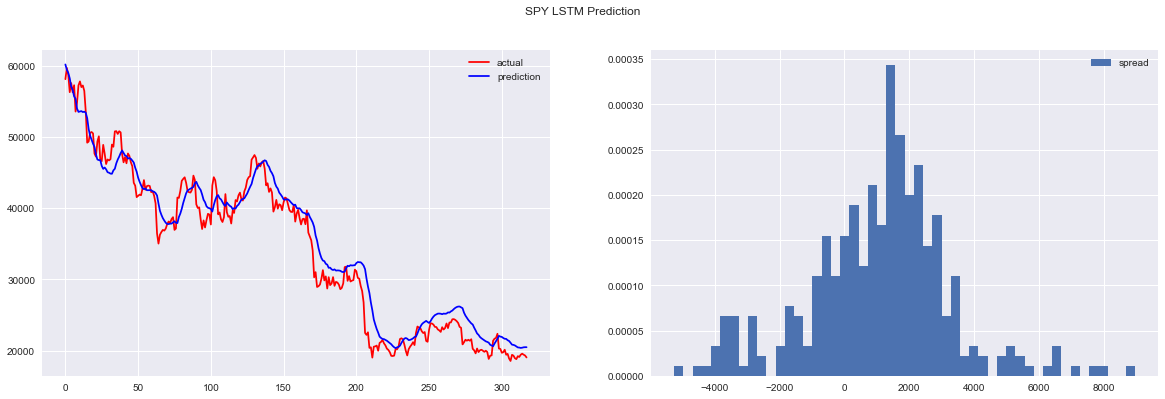

In [27]:
#### PLOT RESULTS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');

In [28]:
X_test.shape

(318, 60, 1)

In [29]:
std = np.copy(scaled_test_data)
std.shape

(378, 1)

In [30]:
pr = []
pr = np.array(pr)


In [31]:
for i in range (0,5):
    m=[]
    m.append(std[318+i:378+i, 0])
    m1 = np.array(m)
    m2 = np.reshape(m1, (m1.shape[0], m1.shape[1], 1))
    p = model.predict(m2)
    std = np.append(std, p)
    std = np.reshape(std, (-1, 1))
    pr = np.append(pr, scaler.inverse_transform(p).flatten())

1/1 [==============================] - 0s 24ms/step


In [32]:
pr

array([20425.25390625, 20691.89648438, 20943.57617188, 21214.50585938,
       21504.55273438])